In [ ]:
### TODO:
#   - najdi primerni podatkovni bazi za regresijo in klasifikacijo
#   - omogoči naključno rezanje uteži
#   - !!ustvari lažje podajanje hiperparametrov
#   - !!ročno inicializiraj uteži z Gaussian Glorot initialization ALI Gaussian z standard deviation 0.1
#   - !!ustvari lepši ui, ki na boljši način prikaže rezanje in učenje.
#   - podatke kot je early stopping rate, natančnost itd. itd. je treba nekje shraniti in prikazati
#   - !!sproti shranjuj nekatere modele npr. najbolj natančnega, najbolj rezanega ali po vsakem rezanjuž
#   - !!dodaj dve opciji globalno prunanje ali prunanje po sloju
#   - !!izboljšaj early stoppage tako da si shraniš model kot je val večji in ga nato loadaš v primeru če se je učenje prenehalo zaradi early stoppage
#   - v statistiko še dodaj druge metrike kot precision recall in F1
#   - dodaj možnost kjer prunaš samo nekatere uteži npr. samo convolution layerje
#   - !!popravi napako, kjer se zadnja epoha ne pokaže pre early stoppage

### TODO:
#   - probaj densenet brez pretrained uteži
#   - probaj preprečiti rezanje batch norm plasti v densenet
#   - poglej kaki bodo rezultati če znižaš resolucijo slik
#   - probaj znižati learning rate na 1e-5
#   - probaj ročno spremeniti število izhodov za zadnji layer

#POMEMBNO: Za errror pri squeezenet1_1 je kriva glorotova inicializacija uteži

ustvaril sem lažje dodajanje parametrov, izboljšal early stoppage algoritem, 

In [1]:
import torch
import numpy as np
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchinfo
import matplotlib
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from neural_network import *
from dataset_realwaste import *
from iterative_pruning import IterativePruning

#from torchvision.models import squeezenet1_1
#from torchvision.models import densenet121
from torchvision.models import resnet18
from torchvision.models import alexnet

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
NUM_CHANNELS = 9
BATCH_SIZE = 64
NUM_EPOCHS = 100
NUM_PRUNE_ITER = 10
PRUNE_MODE = "global"
PRUNE_PER = 0.2
IMAGE_SIZE = [524, 524] #[28, 28]
LR = 1e-4 #1.2e-3

In [ ]:
## MNIST

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x.expand(3, -1, -1)),
])

##pin_memory in num_workers=6

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_subset, val_subset = torch.utils.data.random_split(mnist_trainset, [50000, 10000], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset=train_subset, shuffle=True, batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_subset, shuffle=False, batch_size=BATCH_SIZE)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True)

In [4]:
## REALWASTE
inputs, targets, label_encoder = getRealWasteDataset()
real_waste_dataset = RealWasteDataset(inputs, targets, IMAGE_SIZE)

train_size = int(0.7 * len(real_waste_dataset))
val_size = int(0.15 * len(real_waste_dataset))
test_size = len(real_waste_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(real_waste_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(1))

train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = BATCH_SIZE)
val_loader = DataLoader(dataset = val_dataset, shuffle = False, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_dataset, shuffle = False, batch_size = BATCH_SIZE)


Velikost učne množice:   3320
Velikost validacijske množice:   711
Velikost testne množice:   712
Dimenzija slik: (3, 524, 524)
['Cardboard' 'Metal' 'Miscellaneous Trash' 'Plastic' 'Cardboard'
 'Miscellaneous Trash' 'Food Organics' 'Cardboard' 'Metal'
 'Miscellaneous Trash' 'Plastic' 'Plastic' 'Glass' 'Cardboard'
 'Miscellaneous Trash' 'Metal' 'Plastic' 'Cardboard' 'Vegetation'
 'Miscellaneous Trash' 'Glass' 'Plastic' 'Metal' 'Cardboard'
 'Textile Trash' 'Miscellaneous Trash' 'Textile Trash' 'Metal'
 'Vegetation' 'Textile Trash' 'Plastic' 'Miscellaneous Trash' 'Vegetation'
 'Plastic' 'Paper' 'Plastic' 'Metal' 'Plastic' 'Food Organics' 'Cardboard'
 'Metal' 'Cardboard' 'Metal' 'Miscellaneous Trash' 'Cardboard' 'Cardboard'
 'Metal' 'Food Organics' 'Paper' 'Plastic' 'Glass' 'Miscellaneous Trash'
 'Miscellaneous Trash' 'Vegetation' 'Paper' 'Metal' 'Metal'
 'Food Organics' 'Glass' 'Metal' 'Cardboard' 'Paper' 'Vegetation' 'Glass']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

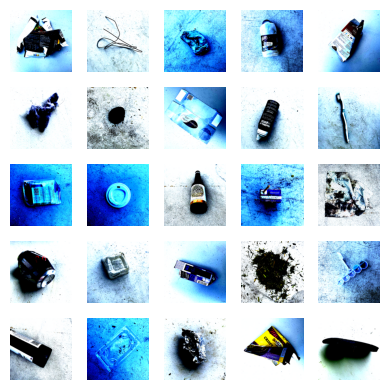

In [5]:
input, targets = next(iter(train_loader))

print(f"Velikost učne množice:   {len(train_dataset)}")
print(f"Velikost validacijske množice:   {len(val_dataset)}")
print(f"Velikost testne množice:   {len(test_dataset)}")
print(f"Dimenzija slik: {input[0].numpy().shape}")

string_decoded = label_encoder.inverse_transform(targets.ravel())
print(string_decoded)

_, axes = plt.subplots(5, 5, figsize=(4, 4), squeeze=False)
for i in range(5):
    for j in range(5):
        axes[i, j].imshow(input[5*i+j].numpy().transpose((1,2,0)), cmap="gray")
        axes[i, j].axis("off")
            
plt.tight_layout()

In [6]:
#model = LeNet300(NUM_CHANNELS)
#model = densenet121(weights="IMAGENET1K_V1")

#model = resnet18(weights="IMAGENET1K_V1")
#num_ftrs = model.fc.in_features
#model.fc = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

model = alexnet(weights="IMAGENET1K_V1")
num_ftrs = model.classifier[6].in_features
model.classifier[6] = torch.nn.Linear(num_ftrs, NUM_CHANNELS)

loss_fn = torch.nn.CrossEntropyLoss()

## KANALI SO NA RGB
print(torchinfo.summary(model, (BATCH_SIZE, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [64, 9]                   --
├─Sequential: 1-1                        [64, 256, 15, 15]         --
│    └─Conv2d: 2-1                       [64, 64, 130, 130]        23,296
│    └─ReLU: 2-2                         [64, 64, 130, 130]        --
│    └─MaxPool2d: 2-3                    [64, 64, 64, 64]          --
│    └─Conv2d: 2-4                       [64, 192, 64, 64]         307,392
│    └─ReLU: 2-5                         [64, 192, 64, 64]         --
│    └─MaxPool2d: 2-6                    [64, 192, 31, 31]         --
│    └─Conv2d: 2-7                       [64, 384, 31, 31]         663,936
│    └─ReLU: 2-8                         [64, 384, 31, 31]         --
│    └─Conv2d: 2-9                       [64, 256, 31, 31]         884,992
│    └─ReLU: 2-10                        [64, 256, 31, 31]         --
│    └─Conv2d: 2-11                      [64, 256, 31, 31]        

In [7]:
for i, data in enumerate(model.named_parameters()):
    name, param = data
    if "weight" in name:
        print(name)
        print(np.shape(param.data))

features.0.weight
torch.Size([64, 3, 11, 11])
features.3.weight
torch.Size([192, 64, 5, 5])
features.6.weight
torch.Size([384, 192, 3, 3])
features.8.weight
torch.Size([256, 384, 3, 3])
features.10.weight
torch.Size([256, 256, 3, 3])
classifier.1.weight
torch.Size([4096, 9216])
classifier.4.weight
torch.Size([4096, 4096])
classifier.6.weight
torch.Size([9, 4096])


In [8]:
ip = IterativePruning(model, apply_weights = False)

ip.start(loss_fn, train_loader, val_loader, test_loader, LR, NUM_EPOCHS , NUM_PRUNE_ITER, PRUNE_MODE, PRUNE_PER, patience = 3, min_delta = 0)

 ===| Prune iteration 1/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
features.0.weight                     0    23232    23232     100.00%
features.3.weight                     0   307200   307200     100.00%
features.6.weight                     0   663552   663552     100.00%
features.8.weight                     0   884736   884736     100.00%
features.10.weight                    0   589824   589824     100.00%
classifier.1.weight                   0 37748736 37748736     100.00%
classifier.4.weight                   0 16777216 16777216     100.00%
classifier.6.weight                   0    36864    36864     100.00%
all                                   0 57031360 57031360     100.00%


Epoch: 7, loss: 0.0692, val_loss: 0.5021 Validating: : 12it [00:08,  1.43it/s]                      
Testing: 12it [00:09,  1.32it/s]                        


Accuracy: 0.872


 ===| Prune iteration 2/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
features.0.weight                   813    22419    23232      96.50%
features.3.weight                 21331   285869   307200      93.06%
features.6.weight                 44902   618650   663552      93.23%
features.8.weight                 67708   817028   884736      92.35%
features.10.weight                45892   543932   589824      92.22%
classifier.1.weight             7957849 29790887 37748736      78.92%
classifier.4.weight             3260404 13516812 16777216      80.57%
classifier.6.weight                   0    36864    36864     100.00%
all                            11398899 45632461 57031360      80.01%


Epoch: 13, loss: 0.0298, val_loss: 0.4456 Validating: : 12it [00:08,  1.39it/s]                      
Testing: 12it [00:09,  1.32it/s]                        


Accuracy: 0.895


 ===| Prune iteration 3/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
features.0.weight                  1468    21764    23232      93.68%
features.3.weight                 38071   269129   307200      87.61%
features.6.weight                 81303   582249   663552      87.75%
features.8.weight                123577   761159   884736      86.03%
features.10.weight                84379   505445   589824      85.69%
classifier.1.weight            14478614 23270122 37748736      61.64%
classifier.4.weight             5710605 11066611 16777216      65.96%
classifier.6.weight                   0    36864    36864     100.00%
all                            20518017 36513343 57031360      64.02%


Epoch: 5, loss: 0.0791, val_loss: 0.4482 Validating: : 12it [00:08,  1.41it/s]                      
Testing: 12it [00:09,  1.33it/s]                        


Accuracy: 0.867


 ===| Prune iteration 4/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
features.0.weight                  2080    21152    23232      91.05%
features.3.weight                 54041   253159   307200      82.41%
features.6.weight                115737   547815   663552      82.56%
features.8.weight                175407   709329   884736      80.17%
features.10.weight               119153   470671   589824      79.80%
classifier.1.weight            19699601 18049135 37748736      47.81%
classifier.4.weight             7647293  9129923 16777216      54.42%
classifier.6.weight                   0    36864    36864     100.00%
all                            27813312 29218048 57031360      51.23%


Epoch: 6, loss: 0.0749, val_loss: 0.4150 Validating: : 12it [00:08,  1.42it/s]                      
Testing: 12it [00:09,  1.31it/s]                        


Accuracy: 0.881


 ===| Prune iteration 5/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
features.0.weight                  2654    20578    23232      88.58%
features.3.weight                 69378   237822   307200      77.42%
features.6.weight                148126   515426   663552      77.68%
features.8.weight                222279   662457   884736      74.88%
features.10.weight               151184   438640   589824      74.37%
classifier.1.weight            23844587 13904149 37748736      36.83%
classifier.4.weight             9211338  7565878 16777216      45.10%
classifier.6.weight                   0    36864    36864     100.00%
all                            33649546 23381814 57031360      41.00%


Epoch: 6, loss: 0.0933, val_loss: 0.5305 Validating: : 12it [00:08,  1.43it/s]                      
Testing: 12it [00:09,  1.31it/s]                        


Accuracy: 0.890


 ===| Prune iteration 6/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
features.0.weight                  3148    20084    23232      86.45%
features.3.weight                 82079   225121   307200      73.28%
features.6.weight                175745   487807   663552      73.51%
features.8.weight                263982   620754   884736      70.16%
features.10.weight               179491   410333   589824      69.57%
classifier.1.weight            27121907 10626829 37748736      28.15%
classifier.4.weight            10492182  6285034 16777216      37.46%
classifier.6.weight                   0    36864    36864     100.00%
all                            38318534 18712826 57031360      32.81%


Epoch: 4, loss: 0.1290, val_loss: 0.4942 Validating: : 12it [00:08,  1.48it/s]                      
Testing: 12it [00:08,  1.36it/s]                        


Accuracy: 0.861


 ===| Prune iteration 7/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
features.0.weight                  3622    19610    23232      84.41%
features.3.weight                 94096   213104   307200      69.37%
features.6.weight                202040   461512   663552      69.55%
features.8.weight                303633   581103   884736      65.68%
features.10.weight               206256   383568   589824      65.03%
classifier.1.weight            29686169  8062567 37748736      21.36%
classifier.4.weight            11557910  5219306 16777216      31.11%
classifier.6.weight                   0    36864    36864     100.00%
all                            42053726 14977634 57031360      26.26%


Epoch: 9, loss: 0.0681, val_loss: 0.4315 Validating: : 12it [00:08,  1.46it/s]                      
Testing: 12it [00:08,  1.35it/s]                        


Accuracy: 0.858


 ===| Prune iteration 8/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
features.0.weight                  4047    19185    23232      82.58%
features.3.weight                105132   202068   307200      65.78%
features.6.weight                227337   436215   663552      65.74%
features.8.weight                341179   543557   884736      61.44%
features.10.weight               231511   358313   589824      60.75%
classifier.1.weight            31663497  6085239 37748736      16.12%
classifier.4.weight            12469177  4308039 16777216      25.68%
classifier.6.weight                   0    36864    36864     100.00%
all                            45041880 11989480 57031360      21.02%


Epoch: 8, loss: 0.0511, val_loss: 0.4930 Validating: : 12it [00:07,  1.52it/s]                      
Testing: 12it [00:08,  1.37it/s]                        


Accuracy: 0.888


 ===| Prune iteration 9/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
features.0.weight                  4412    18820    23232      81.01%
features.3.weight                114473   192727   307200      62.74%
features.6.weight                247930   415622   663552      62.64%
features.8.weight                371966   512770   884736      57.96%
features.10.weight               252646   337178   589824      57.17%
classifier.1.weight            33222530  4526206 37748736      11.99%
classifier.4.weight            13218445  3558771 16777216      21.21%
classifier.6.weight                   0    36864    36864     100.00%
all                            47432402  9598958 57031360      16.83%


Epoch: 7, loss: 0.0805, val_loss: 0.5151 Validating: : 12it [00:07,  1.51it/s]                      
Testing: 12it [00:08,  1.38it/s]                        


Accuracy: 0.878


 ===| Prune iteration 10/10 |=== 
Name                              Zeros Nonzeros      All Nonzeros(%)
features.0.weight                  4811    18421    23232      79.29%
features.3.weight                124262   182938   307200      59.55%
features.6.weight                269806   393746   663552      59.34%
features.8.weight                403786   480950   884736      54.36%
features.10.weight               274401   315423   589824      53.48%
classifier.1.weight            34410945  3337791 37748736       8.84%
classifier.4.weight            13856808  2920408 16777216      17.41%
classifier.6.weight                   0    36864    36864     100.00%
all                            49344819  7686541 57031360      13.48%


Epoch: 4, loss: 0.1676, val_loss: 0.4752 Validating: : 12it [00:07,  1.52it/s]                      
Testing: 12it [00:08,  1.37it/s]                        


Accuracy: 0.858




In [ ]:
#model = torch.load("model_lenet_mnist.pt")
#test(model, test_loader, len(mnist_testset))